# [GAN] 딥러닝 생성적 대립 신경망 GAN 기초 실습 입문하기

### 주소 : https://dacon.io/codeshare/4231?utm_source=dacrew&utm_medium=433691&utm_campaign=dacrew_1

In [1]:
# GAN 이란:

# 생성적 대립 신경망(Generative Adversarial Network; GAN)

# 생성모델과 판별모델이 경쟁하면서 실제와 가까운 이미지, 동영상, 음성 등을
# 자동으로 만들어 내는 딥러닝 방식 중 하나이다.

# 대표적인 특징

# Unsupervised Learning(비지도학습)의 대표적인 알고리즘
# 서로 대립하는 역할의 두 모델을 생성해, 적대적 경쟁시키면서 발전해 학습하는 방법
# 이미지, 음성, sequential data 등 원하는 형태의 데이터를 만드는 모델
# Generator: 생성자, 가짜 이미지 생성
# Discriminator: 판별자, 이미지의 진위 여부 판별

In [2]:
# 실습

# MNIST 이미지 생성

# 텐서플로우에서 제공하는 mnist 이미지 셋을 이용하여 GAN을 실습해보도록 하겠다.
# mnist 이미지 셋은 다음과 같이 28 x 28 사이즈의 손으로 쓴 숫자들로 이루어져 있다.
# 0 ~ 9까지 총 10개의 클래스를 가지고 있으며, 색상 채널이 없는 흑백 이미지이다.

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

shape를 보면 train은 28 x 28 픽셀로 6만 개의 그림이 있다.  
test는 28 x 28 픽셀로 1만개의 그림이 있다.

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
x_test.shape

(10000, 28, 28)

##### Nomarlize

In [7]:
x_train.min(), x_train.max()

(0, 255)

generator에서 tanh를 activation으로 활용할 것이다.  
tanh를 활용하면 output이 -1 ~ 1 사이로 나오기 때문에  
Normalize를 해줄 때 127.5로 나눈 뒤 1을 빼주어  
범위를 -1 ~ 1 사이로 만들어 준다.

In [8]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 / -1

In [9]:
x_train.min(), x_train.max()

(-1.0, 1.0)

x_train 값은 현재 28 x 28로 되어 있는 것을 Flatten하게 차원을 줄여 보겠다.

In [10]:
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

##### Hyperparameters

GAN에 입력되는 Noise에 대한 차원을 설정해보도록 하겠다.

In [11]:
NOISE_DIM = 10

Optimizer를 adam으로 정의 해보도록 하겠다.  
Vanilla GAN 에서는 learning_rate = 0.0002, beta_1로 튜닝 해주는 것이 학습을 잘한다고 함

In [12]:
adam = Adam(lr=0.0002, beta_1=0.5)

C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


##### Generator 생성자 정의

In [13]:
generator = Sequential([
    Dense(256, input_dim=NOISE_DIM),
    LeakyReLU(0.2),
    Dense(512),
    LeakyReLU(0.2),
    Dense(1024),
    LeakyReLU(0.2),
    Dense(28*28, activation='tanh')
])

Generator의 Shape와 파라미터 상세 정보를 살펴보겠다.

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

##### Discriminator 판별자 정의

In [15]:
discriminator = Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2),
    Dropout(0.3),
    Dense(512),
    LeakyReLU(0.2),
    Dropout(0.3),
    Dense(256),
    LeakyReLU(0.2),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

Discriminator의 Shape와 파라미터 상세 정보를 살펴보겠다.

In [16]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

판별자를 binary_crossentropy 로스를 가지도록 compile 해준다.

In [17]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

##### GAN 구성

이제 생성자와 판별자를 연결해 보도록 하겠다.  
GAN 모델에서는 생성자(generator)만 학습하도록 하고,  
판별자(discriminator)는 학습하지 않도록 합니다.

In [18]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))  # 10차원
x = generator(inputs=gan_input)
output = discriminator(x)

In [19]:
gan = Model(gan_input, output)

gan의 Shape와 파라미터 상세 정보를 살펴보겠다.

In [20]:
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 sequential (Sequential)     (None, 784)               1463312   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


##### Compile

GAN을 binary_crossentropy 로스로 컴파일 해준다.

In [21]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

##### Batch

MNIST 이미지 batch가 차례대로 생성되도록 이미지 batch를 생성함

In [22]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size : (i + 1)*batch_size]
        batches.append(batch)
    return np.asarray(batches)

예를 들어, 784개 피쳐를 가진 6만개 데이터를

In [23]:
x_train.shape

(60000, 784)

get_batches를 이용하여 784개 피쳐를 가진 6천개 x 10 데이터로 바꿔줌

In [24]:
get_batches(x_train, 10).shape

(6000, 10, 784)

##### 시각화를 위한 유틸 함수 정의

In [25]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))

    # 샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)

    plt.figure(figsize=(8, 4))

    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

##### 학습 과정

배치사이즈를 256  
에포크를 50회로 두겠다.

In [26]:
BATCH_SIZE = 256
EPOCHS = 50

판별자(discriminator)와 GAN 모델의 loss 측정을 위한 list를 생성함

In [27]:
d_losses = []
g_losses = []

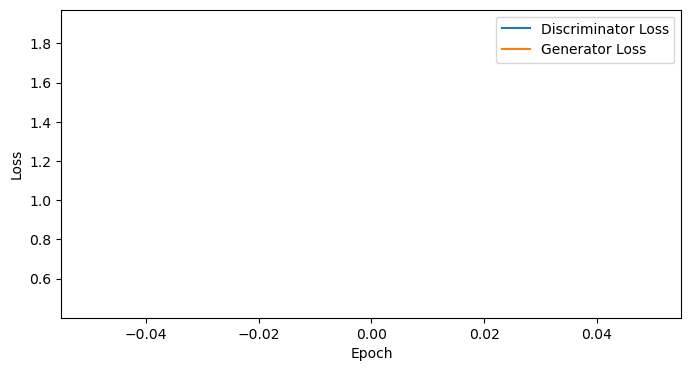

epoch: 1, Discriminator Loss: 0.47227659821510315, Generator Loss: 1.9000840187072754
1/1 [==============================] - 0s 54ms/step


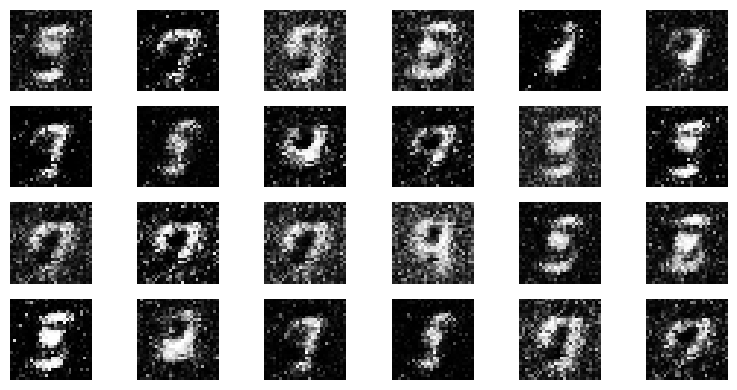

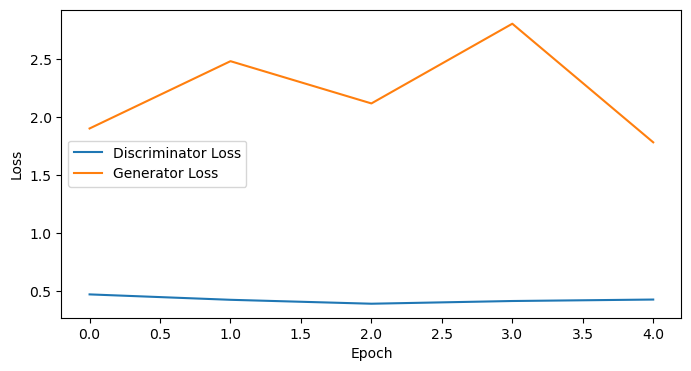

epoch: 5, Discriminator Loss: 0.4266596376895905, Generator Loss: 2.2154653549194334
1/1 [==============================] - 0s 24ms/step


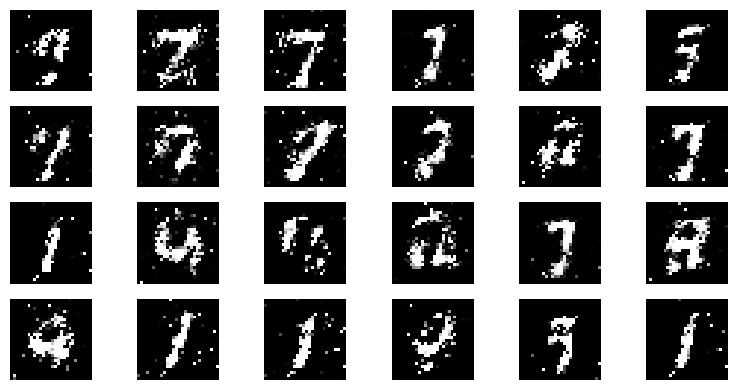

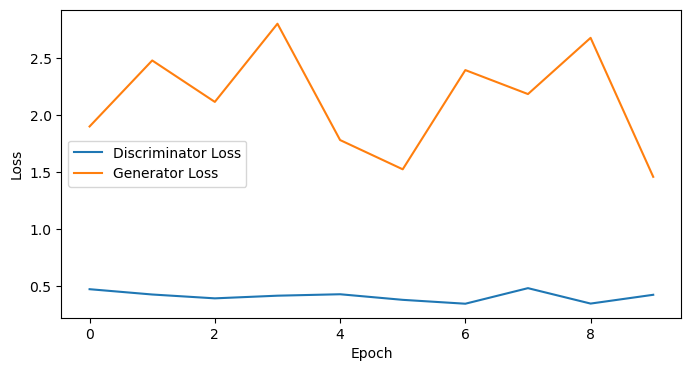

epoch: 10, Discriminator Loss: 0.41078497767448424, Generator Loss: 2.1316464066505434
1/1 [==============================] - 0s 25ms/step


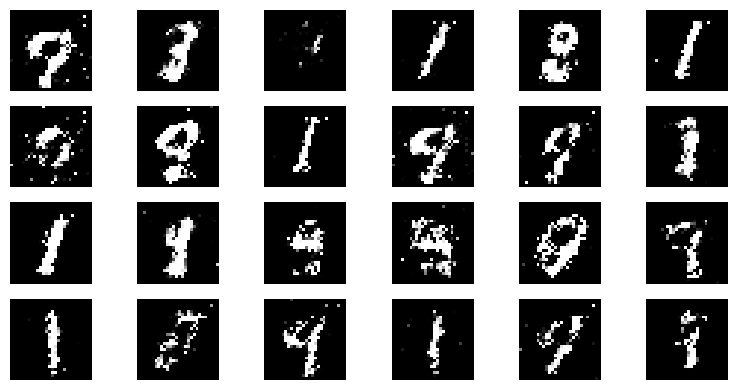

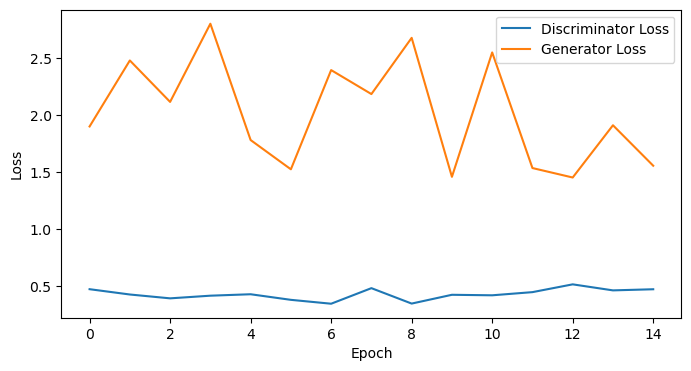

epoch: 15, Discriminator Loss: 0.4281023403008779, Generator Loss: 2.021314263343811
1/1 [==============================] - 0s 25ms/step


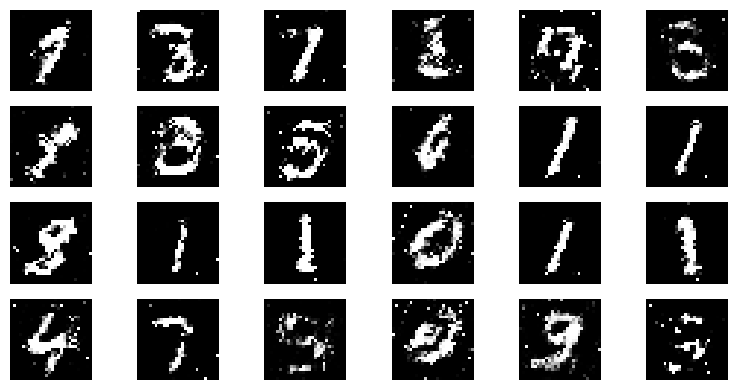

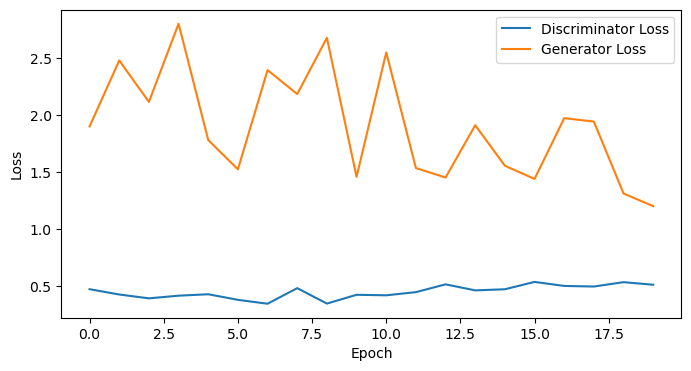

epoch: 20, Discriminator Loss: 0.44999087899923323, Generator Loss: 1.909387993812561
1/1 [==============================] - 0s 23ms/step


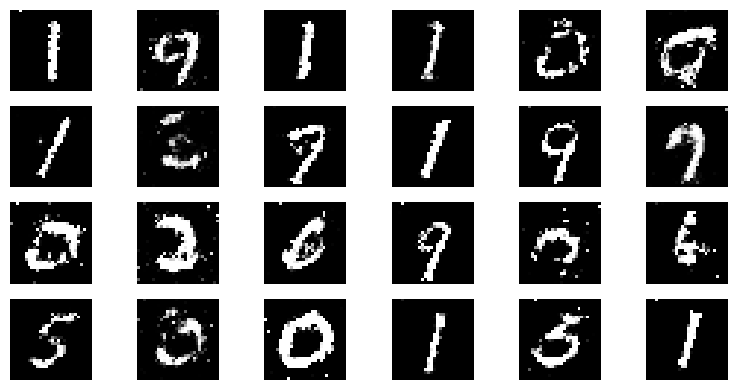

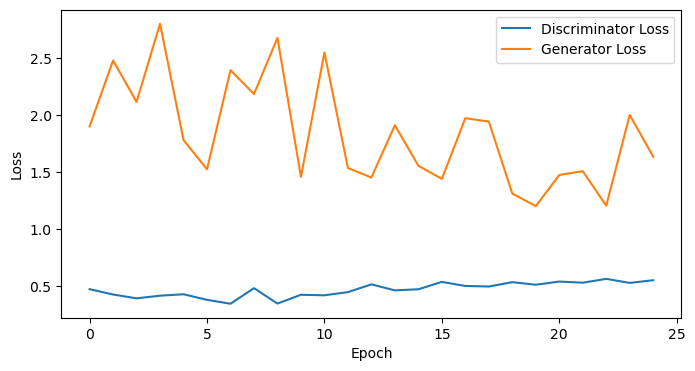

epoch: 25, Discriminator Loss: 0.4684017789363861, Generator Loss: 1.8404129791259765
1/1 [==============================] - 0s 22ms/step


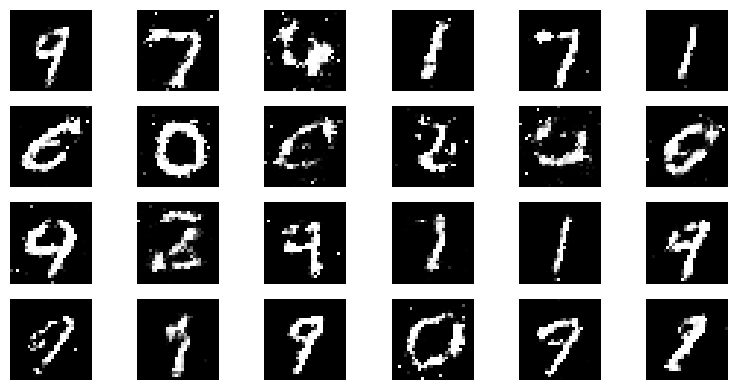

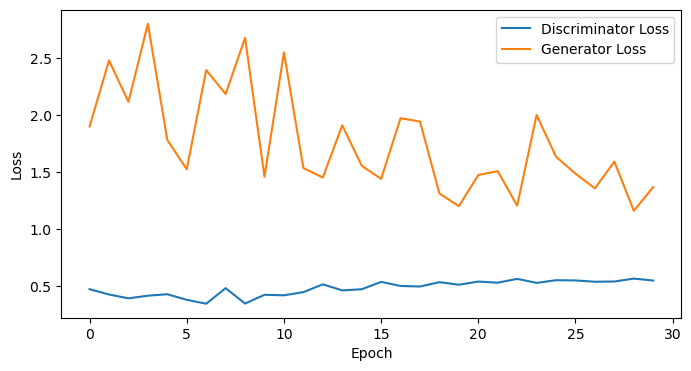

epoch: 30, Discriminator Loss: 0.481669611732165, Generator Loss: 1.7657790581385295
1/1 [==============================] - 0s 43ms/step


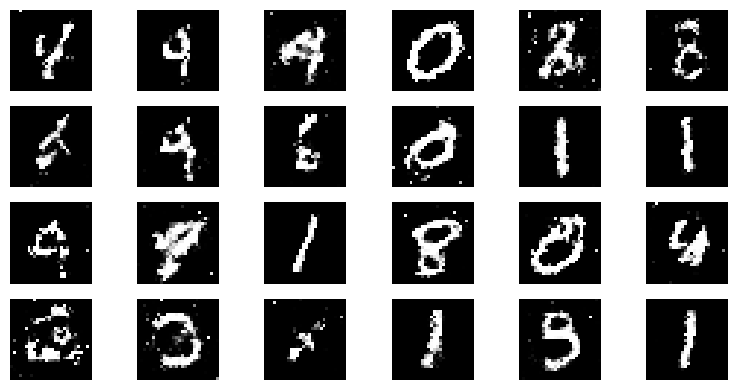

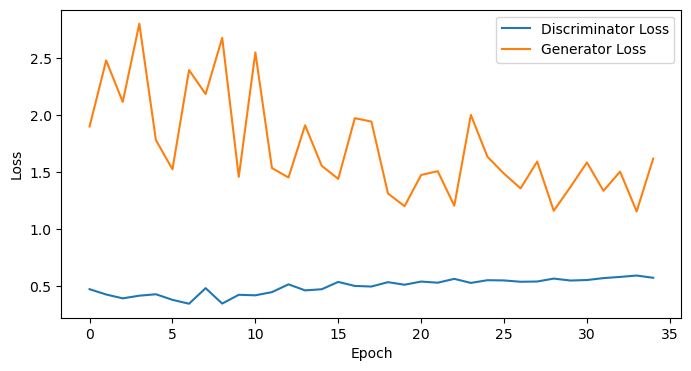

epoch: 35, Discriminator Loss: 0.4947687906878335, Generator Loss: 1.7191446031842912
1/1 [==============================] - 0s 24ms/step


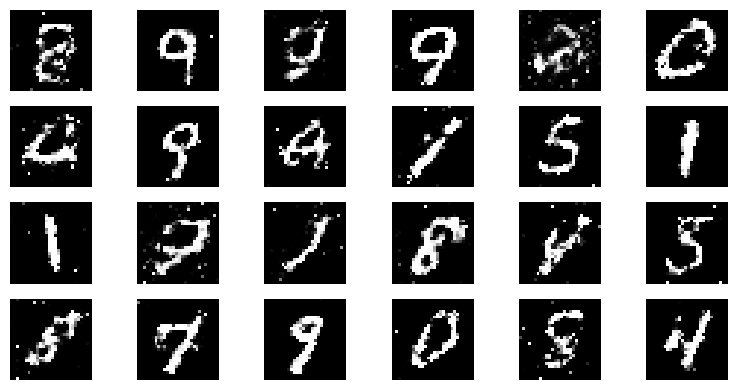

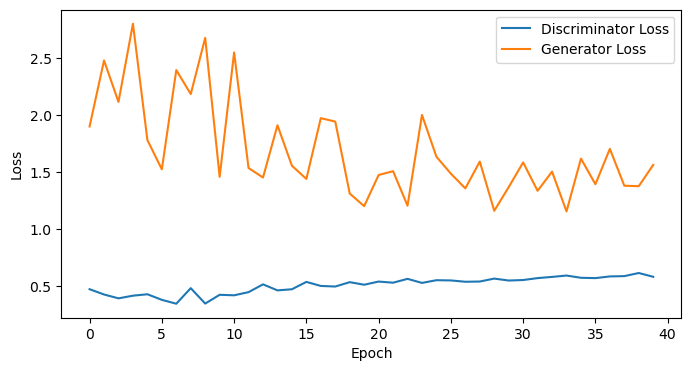

epoch: 40, Discriminator Loss: 0.5063255779445172, Generator Loss: 1.6896476238965987
1/1 [==============================] - 0s 24ms/step


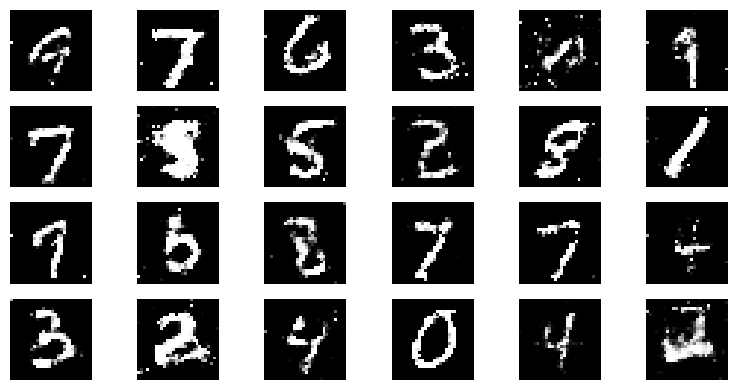

In [28]:
d이다.
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(x_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1,1,size=[BATCH_SIZE, NOISE_DIM])

        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise, verbose=0)  # verbose 학습 결과 안 알려줌?

        # GAN에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])

        # GAN에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9

        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis) 

        # GAN 훈련
        noise = np.random.uniform(-1,1,size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)

        # Discriminator의 판별 학습을 방지함
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)